# PID Graph Key Performance Indicators (KPIs)

This notebook uses the [DataCite GraphQL API](https://api.datacite.org/graphql) to fetch summary statistics about nodes and connections.

In [84]:
# Prepare the R graphql client.

library("httr")
library("ghql")
library("jsonlite")
library("IRdisplay")
library("dplyr")
library("igraph")

cli <- GraphqlClient$new(
  url = "https://api.datacite.org/graphql"
)
qry <- Query$new()

In [85]:
query <- '{
  publications {
    totalCount
    publicationConnectionCount
    datasetConnectionCount
    softwareConnectionCount
    researcherConnectionCount
    funderConnectionCount
  }
  datasets {
    totalCount
    datasetConnectionCount
    softwareConnectionCount
    researcherConnectionCount
    funderConnectionCount
  }
  softwares {
    totalCount
    softwareConnectionCount
    researcherConnectionCount
    funderConnectionCount
  }
  researchers {
    totalCount
  }
  funders {
    totalCount
  }
}
'

In [86]:
# Run the query and parse the JSON response

qry$query('getdata', query)
data <- fromJSON(cli$exec(qry$queries$getdata))

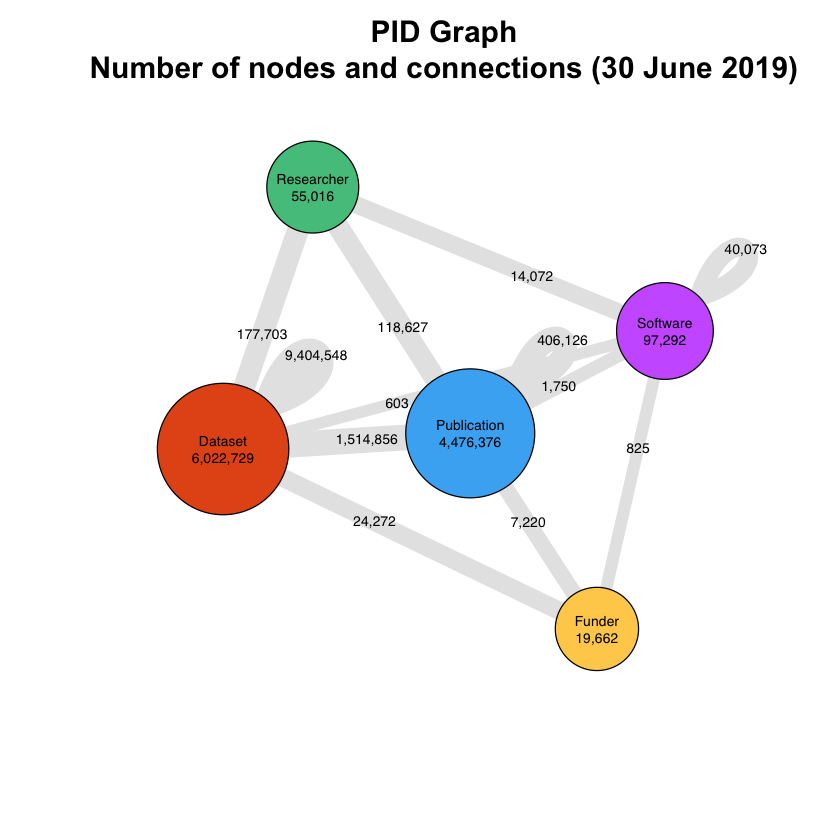

In [120]:
# generate data frame for nodes
publications <- data.frame(id=c('Publication'), count=data$data$publications$totalCount)
datasets <- data.frame(id=c('Dataset'), count=data$data$datasets$totalCount)
softwares <- data.frame(id=c('Software'), count=data$data$softwares$totalCount)
researchers <- data.frame(id=c('Researcher'), count=data$data$researchers$totalCount)
funders <- data.frame(id=c('Funder'), count=data$data$funders$totalCount)
nodes <- rbind(publications, datasets, softwares, researchers, funders)

edges <- data.frame(to=character(), from=character())
edges <- rbind(edges, data.frame(from="Publication", to="Publication", count=data$data$publications$publicationConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Dataset", count=data$data$publications$datasetConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Software", count=data$data$publications$softwareConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Researcher", count=data$data$publications$researcherConnectionCount))
edges <- rbind(edges, data.frame(from="Publication", to="Funder", count=data$data$publications$funderConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Dataset", count=data$data$datasets$datasetConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Software", count=data$data$datasets$softwareConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Researcher", count=data$data$datasets$researcherConnectionCount))
edges <- rbind(edges, data.frame(from="Dataset", to="Funder", count=data$data$datasets$funderConnectionCount))
edges <- rbind(edges, data.frame(from="Software", to="Software", count=data$data$softwares$softwareConnectionCount))
edges <- rbind(edges, data.frame(from="Software", to="Researcher", count=data$data$softwares$researcherConnectionCount))
edges <- rbind(edges, data.frame(from="Software", to="Funder", count=data$data$softwares$funderConnectionCount))

# generate graph
g <- graph_from_data_frame(edges, vertices=nodes)

# add node colors
col = c('#e45718','#fecf59','#48b1f4','#53c48c','#cc66ff')
V(g)[1]$color<-'#48b1f4'
V(g)[2]$color<-'#e45718'
V(g)[3]$color<-'#cc66ff'
V(g)[4]$color<-'#53c48c'
V(g)[5]$color<-'#fecf59'

# add labels
V(g)$label=paste(nodes$id, format(V(g)$count, big.mark=",", trim=TRUE), sep="\n")
E(g)$label <- format(E(g)$count, big.mark=",", trim=TRUE)

# calculate node size and edge width
V(g)$size <- log(V(g)$count, 1.3)
E(g)$width <- log(E(g)$count, 2)

E(g)$arrow.mode <- 0
l <- layout_nicely(g)
plot(g, layout=l, arrow.mode=0, vertex.label.color=c("black"), vertex.label.family="Helvetica", vertex.label.cex=c(0.7), edge.color=c("gray90"), edge.label.color=c("black"), edge.label.family="Helvetica", edge.label.cex=c(0.7), edge.loop.angle=-pi/4)
title(paste("PID Graph\nNumber of nodes and connections",
format(Sys.Date(), "(%d %B %Y)"), sep=" "),cex.main=1.5)